# Evaluation et sélection de modèles

Nous allons maintenant nous intéresser à la façon d'**évaluer une modèle** et de régler ses hyperparamètres, soit l'ensemble des paramètres qui définissent un modèle.

In [43]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


## Validation d'un modèle

Une étape déterminante du machine learning est de s'assurer des performances d'un modèle étudié : on cherche à vérifier à quel point l'information contenue dans le jeu de données est captée par notre modélisation. Il y a quelques pièges à éviter que nous allons aborder.

On s'intéresse à nouveau aux données d'iris. Comment s'assurer de la qualité de nos prédictions?


In [44]:
from sklearn.datasets import load_iris
digits = load_iris()
X = digits.data
y = digits.target

On utilise un nouvel algorithme: la **méthode des K plus proches voisins**. L'algorithme sélectionne le label associé au point le plus proche dans le jeu de données. 

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1) # K = 1, uniquement le point le plus proche
knn.fit(X, y)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Maintenant on utilise notre modèle pour **prédire** les labels de nos données

In [49]:
y_pred = knn.predict(X)

On peut à présent calculer le nombre d'exemples qui nous avons correctement prédits:

In [50]:
print("{0} / {1} correctement prédits".format(np.sum(y == y_pred), len(y)))

150 / 150 correctement prédits


Nous obtenons un classification parfaite !

**Question: qu'est ce qui cloche dans notre approche?**

## Ensemble de validation

Notre erreur est la suivante: nous avons évalué la performance de notre algorithme sur les mêmes données utilisées en apprentissage. **Ce n'est généralement pas la bonne façon de procéder**. Si on optimise notre algorithme de cette façon, on va avoir tendant à **sur-apprendre** nos données: nous modélisons du bruit en quelques sortes.

La bonne façon de faire est d'évaluer la performances du modèle uniquement sur des données qu'il n'a pas utilisé en apprentissage. Nous utilsons pour cela la méthode `train_test_split` de `Scikit-Learn`: 


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((112, 4), (38, 4))

On apprend le modèle sur un sous ensemble des données (*train*) et on évalue la performance sur les données restantes (*test*).

In [54]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correctement prédits".format(np.sum(y_test == y_pred), len(y_test)))

37 / 38 correctement prédits


On obtient une estimation plus fiable de la qualité du modèle.

La mesure utilisé, qui calcule le ratio de prédictions correctes sur le nombre total d'exemples, est appelée **exactitude (*accuracy* en anglais)**, et peut se calculer en utilisant le module suivant:

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9736842105263158

Elle est également directement disponible via la méthode ``model.score``:

In [57]:
knn.score(X_test, y_test)

0.9736842105263158

En respectant ce principe, on peut maintenant comparer les performances du KNN pour différentes tailles de voisinages K:

In [58]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, ' voisins : ', knn.score(X_test, y_test))

1  voisins :  0.9736842105263158
5  voisins :  1.0
10  voisins :  0.9473684210526315
20  voisins :  0.9473684210526315
30  voisins :  0.9473684210526315


Dans ce cas, un "petit" voisinage semble capter au mieux notre signal.

## Validation croisée

Le découpage train/test a pour défaut de ne pas tirer parti de l'ensemble des données disponibles. Dans l'exemple ci -dessus, 3/4 des données seulement sont utilisées en apprentissage et 1/4 pour le test. La validation croisée est une autre option: dans cet exemple on sépare le jeu de données en deux ensembles de tailles égales et on répète l'apprentissage et la validation sur chaque moité des données:


In [65]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=2)
X1.shape, X2.shape

((75, 4), (75, 4))

In [66]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.96
0.9733333333333334


En utilisant une validation croisée sur 2 ensembles de données, on va donc obtenir 2 métriques pour ces mêmes paramètres.

La validation croisée, si effectuée sur plus de 2 sous-ensembles, peut rapidement devenir problématique à coder. Fort heureusement, scikit-learn propose une méthode pour faciliter cette technique: 


In [67]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=2) # cv=2 i.e. 2 découpages disjoints
cv.mean()

np.float64(0.9466666666666667)

### Cross-validation à $K$ découpes

Nous avons précédemment découpés nos données en 2 ensembles égaux. On va maintenant généraliser à $K$ découpages. On va donc effectuer $K$ apprentissages, chacun des $K$ sous-ensembles est utilisé une fois en validation et tous les autres pour l'apprentissage du modèle.

Testons pour $K=10$ :

In [68]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10) # cv=10 pour 10 découpes

array([1.        , 0.93333333, 1.        , 0.93333333, 0.86666667,
       1.        , 0.86666667, 1.        , 1.        , 1.        ])

Cette approche nous fournit une meilleure approximation de la qualité de nos prédictions.

## Sur-apprentissage, sous-apprentissage et sélection de modèle

Maintenant que nous avons exposé les concepts de validation et de validation croisée, on va entrer un peu plus dans le détail du processus de selection de modèle.


Les problèmes associés à ces concepts, parfois survolés dans les études de machine learning, constituent pourtant une étape primordiale du protocole expérimental à mettre en place. Etre en mesure de déterminer quel modèle vous offre la meilleure perfomance est indispensable à la bonne résolution du problème.

Notamment, on doit être en mesure de répondre aux questions suivantes:

**Si notre modèle a des perfomances insuffisantes, que devons-nous faire?**

- Simplifier ou complexifier notre modèle?
- Ajouter de nouvelles variables en entrée du modèle?
- Augmenter le nombre d'exemples en apprentissage (i.e. la taille du jeu de données)?

La réponse est parfois contre-intuitive, particulièrement **lorsque l'utilisation d'un modèle plus complexe dégrade nos perfomances initiales**. Egalement, **l'ajout de nouvelles données n'est pas forcément synonyme de meilleures performances**. C'est votre aptitude à déterminer quelle évolution va améliorer votre modèle qui fera de vous un data scientist de talent !


### Illustration du compromis biais - variance

Pour comprendre ce principe, on va étudier un problème de modélisation sur une unique variable. Cela va nous aider à visualiser de manière simple les données et le modèle, et les observations que nous ferons se généralisent à des problèmes plus complexes en grandes dimensions. Nous allons considérer un problème simple de **régréssion linéaire** en utilisant le module `sklearn.linear_model`

Nous créons une fonction simple mais non-linéaire pour générer un jeu de données:

In [69]:
def test_func(x: np.ndarray, err: float=0.5) -> np.ndarray:
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Générons à présent nos données:

In [70]:
def make_data(N: int=40, error: float=1.0, random_seed: int=1) :
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

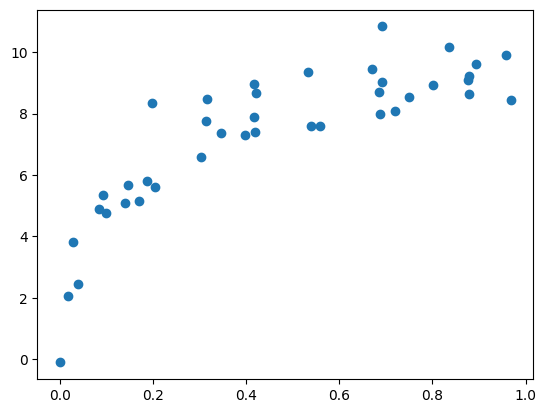

In [71]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

Dans un premier temps, on souhaite utiliser une régression dsur ces données. Pour cela, on ajuste la méthode de régression linéaire de `Scikit-Learn` sur nos données:

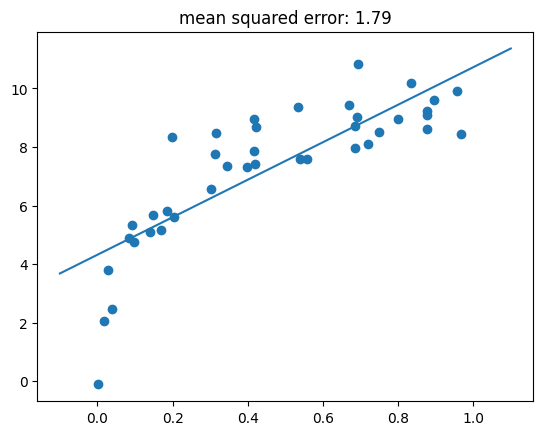

In [72]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

On obtient la drotie qui représente au mieux nos données mais on peut facilement conclure en observant que la solution est loin d'être optimale, car trop simple. On parle de **sous-apprentissage** des données, le modèle dispose d'un **biais élevé**.

Tentons d'améliorer nos performances en utilisant un modèle plus sophistiqué. Pour cela, on rajoute des dégrés de liberté au modèle, en utilisant une régression polynomiale de degré 2. On doit transformer nos données d'entrée (i.e. notre variables $x$) pour permettre au modèle d'ajuster également sur $x^2$. `Scikit-Learn` permet d'effectuer cette étape facilement en utilisant le prétraitement  ``PolynomialFeatures`` que l'on va coupler à notre régression linéaire à l'intérieur d'un ``Pipeline``.

Voyons ce que cela donne en pratique:


In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline

def PolynomialRegression(degree: int=2, **kwargs) -> Pipeline:
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Notre droite précédente devient alors une coubre quadratique: 

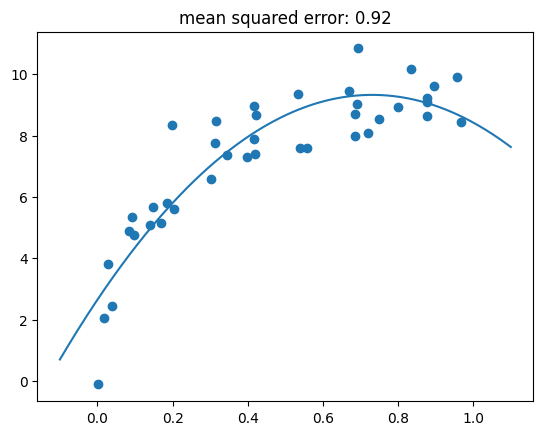

In [74]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

Notre erreur (MSE) a diminué, notre apprentissage est de meilleure qualité.

Que ce passe-t-il si on augmente foretement les dégrés de liberté du modèle?

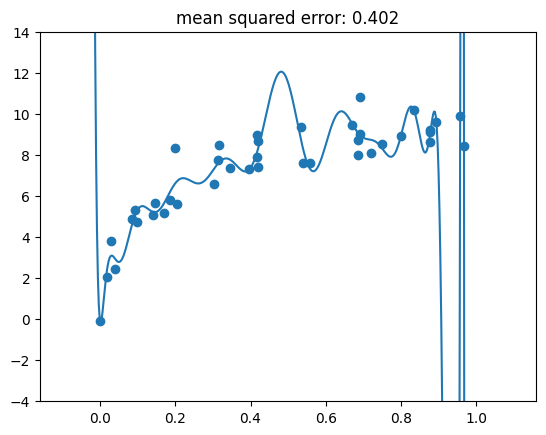

In [75]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

En augmentant significativement le dégré du modèle polynomial, on obtient un modèle qui ne correspond clairement plus à notre distribution initiale, mais modélise plutôt le bruit statistique de nos données. Pour cette raison, on parle de modèle à **forte variance** et de **sur-apprentissage** des données.

**Remarque**: malgré un surapprentissage évident, on constate que notre erreur a significativement diminué !

### Eviter le sur-apprentissage en utilisant la courbe de validation

Mesurer l'erreur d'un modèle sur les dnnées d'apprentissage uniquement est clairement insuffisant. Pour mieux interpréter les erreurs du système, on utilise la **validation croisée** définie précédemment.

Pour determiner le degré de polynome optimal, on va tracer les courbes de erreurs en apprentissage et en validation pour différentes valeurs de degré polynomial. On utilise la fonction  `validation_curve` pour visualiser ceci de manière claire:


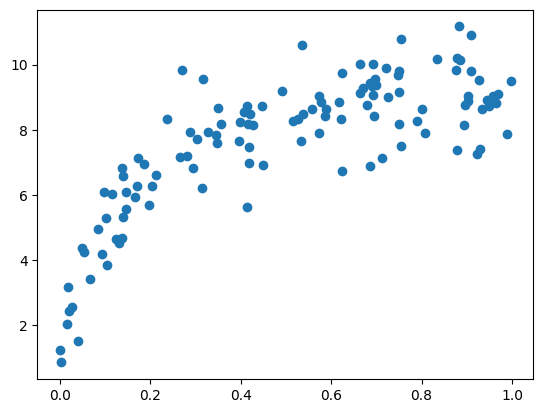

In [76]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [77]:
from sklearn.model_selection import validation_curve

def rms_error(model, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 16)
val_train, val_test = validation_curve(
    PolynomialRegression(),
    X,
    y,
    param_name='polynomialfeatures__degree',
    param_range=degree,
    cv=7,
    scoring=rms_error
)

Traçons à présent les courbes des erreurs:

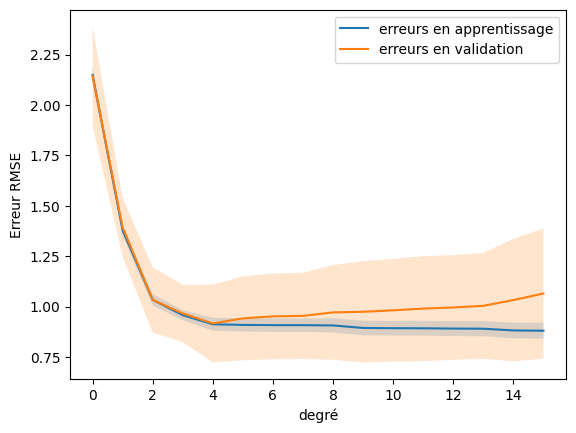

In [78]:
def plot_with_err(x: np.ndarray, data: np.ndarray, **kwargs) -> None:
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='erreurs en apprentissage')
plot_with_err(degree, val_test, label='erreurs en validation')
plt.xlabel('degré'); plt.ylabel('Erreur RMSE')
plt.legend();

Ces courbes sont représentatives de ce qu'on observe généralemlent:

1. Pour une faible complexité de modèle, les erreurs en apprentissage et validation sont très proches. Cela témoigne d'un **sous-apprentissage** des données et d'une complexité trop faible du modèle. Le modèle ne capte la totalité de la distribution mais généralise bien sur de nouvelles données. C'est un modèle à **biais élevé**

2. Quand la complexité augmente, les courbes divergent. Le modèle commence à **sur-apprendre**, il dispose d'un complexité telle qu'il commence à capter le bruit présent dans les données. C'est un modèle à **forte variance**. Le modèle capte certes plus de variance sur les données d'apprentissage mais ce gain aura un impact négatif lors de la généralisation sur de nouvelles données.

3. On remarque enfin que l'erreur d'apprentissage diminue presque systématiquement quand la complexité du modèle augmente. Le gain de complexité permet au modèle de s'ajuster sur le bruit des données donc l'erreur d'apprentissage diminue.

D'apres nos courbes d'erreurs on estime que notre meilleur modèle est obtenu pour une degré polynomial égal à 4:

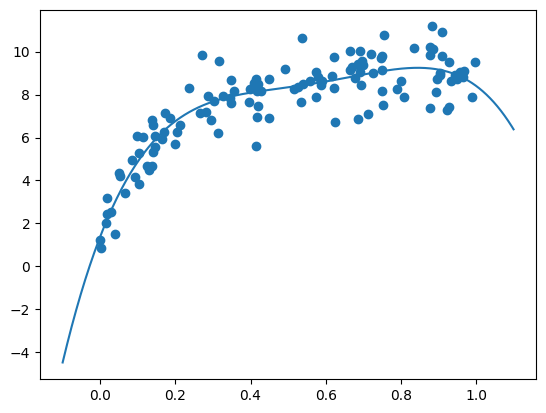

In [79]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

## Bilan

Nous avons présenté divers concepts et modules Scikit-learn permettant la validation des performances de modèles.

- L'**erreur d'apprentissage** indique le niveau d'ajustement du modèle aux données apprentissage. C'est un bon indicateur des perfomances brutes du modèle.
- L'**erreur de validation** indique le capacité du modèle à généraliser sur de nouvelles données. Il est possible de l'estimer par validation croisée.
- Les **courbes d'erreurs** d'apprentissage et de validation comme fonction de la **complexité du modèle** indique:
  + un **sous-apprentissage** en cas de courbes proches
  + un **sur-apprentissage** en cas de courbes éloignées
  + un **zone optimale** de complexité au point de croisement.
  